# gsim.meep — MEEP Photonic FDTD Simulation

This notebook demonstrates the `gsim.meep` module workflow:

1. Create a gdsfactory component
2. Configure simulation with fluent API (including **performance optimizations**)
3. Validate config
4. **Visualize 3D geometry** (client-side, no MEEP needed)
5. Write config (GDS + JSON + runner script) to disk
6. Inspect the generated files

> **Note:** MEEP runs on the cloud — no local MEEP installation needed.  
> Geometry is sent as a **GDS file** alongside a JSON config with layer stack info.

### Performance features

| Feature | Speedup | API |
|---------|---------|-----|
| Symmetry exploitation | 2-4x | `sim.set_symmetry(y=-1)` |
| Decay-based stopping | 1.5-3x | `sim.set_wavelength(..., stop_when_decayed=True)` |
| Reduced default margins | 1.3-2x | Default `margin_xy/z` = 0.5 (was 1.0) |
| Fewer frequency points | ~2x | Default `num_freqs` = 11 (was 21) |
| `split_chunks_evenly=False` | MPI balance | Default in `SimConfig` |

In [1]:
import gdsfactory as gf
from gdsfactory.gpdk import get_generic_pdk

pdk = get_generic_pdk()
pdk.activate()

## 1. Create a component

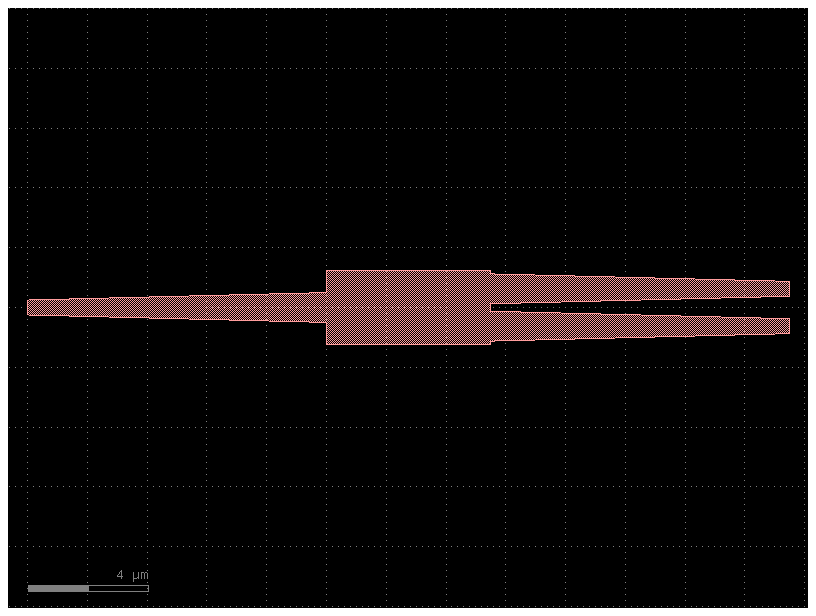

In [2]:
component = gf.components.mmi1x2()
component.plot()

In [3]:
# Inspect ports
for p in component.ports:
    print(f"{p.name}: center={p.center}, width={p.width}, orientation={p.orientation}")

o1: center=(-10.0, 0.0), width=0.5, orientation=180.0
o2: center=(15.5, 0.625), width=0.5, orientation=0.0
o3: center=(15.5, -0.625), width=0.5, orientation=0.0


## 2. Configure MeepSim

In [ ]:
from gsim.meep import MeepSim

sim = MeepSim()

# Set the component geometry
sim.set_geometry(component)

# Set layer stack (from active PDK)
sim.set_stack()

# Configure domain margins and PML (defaults: margin=0.5, dpml=1.0)
sim.set_domain(0.5)

# Crop z-domain tightly to photonic core region
sim.set_z_crop()

# Override material optical properties
sim.set_material("si", refractive_index=3.47)
sim.set_material("SiO2", refractive_index=1.44)

# Configure wavelength range (default num_freqs=11)
# Use decay-based stopping for faster convergence
sim.set_wavelength(
    wavelength=1.55,
    bandwidth=0.1,
    num_freqs=11,
    run_after_sources=100,
    stop_when_decayed=True,
    decay_threshold=1e-3,
)

# Set MEEP grid resolution
sim.set_resolution(pixels_per_um=20)

# Exploit mirror symmetry (MMI is symmetric about y-axis)
sim.set_symmetry(y=-1)

# Output directory
sim.set_output_dir("./meep-sim-test")

Could not parse layer ((WG - DEEP_ETCH) - SHALLOW_ETCH), using (0, 0)
Could not parse layer (SHALLOW_ETCH & WG), using (0, 0)


Z-crop around 'core' [0.00, 0.22] um: window [-0.50, 0.72], 10 layers kept


## 3. Validate configuration

In [5]:
result = sim.validate_config()
print(result)
print(f"Valid: {result.valid}")
if result.errors:
    print("Errors:", result.errors)
if result.warnings:
    print("Warnings:", result.warnings)

Stack validation: PASSED
Valid: True


## 4. Inspect config models

In [6]:
# FDTD config — wavelength/frequency conversion
print(f"Wavelength: {sim.fdtd_config.wavelength} um")
print(f"Bandwidth:  {sim.fdtd_config.bandwidth} um")
print(f"fcen:       {sim.fdtd_config.fcen:.4f} (1/um)")
print(f"df:         {sim.fdtd_config.df:.4f} (1/um)")
print(f"Num freqs:  {sim.fdtd_config.num_freqs}")

# Stopping config
stopping = sim.fdtd_config.stopping
print(f"\nStopping mode: {stopping.mode}")
print(f"  run_after_sources: {stopping.run_after_sources}")
if stopping.mode == "decay":
    print(f"  decay_by:     {stopping.decay_by}")
    print(f"  decay_dt:     {stopping.decay_dt}")
    print(f"  decay_component: {stopping.decay_component}")

# Symmetries
print(f"\nSymmetries: {len(sim.symmetries)}")
for s in sim.symmetries:
    print(f"  Mirror {s.direction}, phase={s.phase}")
print(f"split_chunks_evenly: {sim.split_chunks_evenly}")

Wavelength: 1.55 um
Bandwidth:  0.1 um
fcen:       0.6452 (1/um)
df:         0.0417 (1/um)
Num freqs:  11

Stopping mode: decay
  run_after_sources: 100.0
  decay_by:     0.001
  decay_dt:     50.0
  decay_component: Ez

Symmetries: 1
  Mirror Y, phase=-1
split_chunks_evenly: False


In [7]:
# Resolution config
print(f"Resolution: {sim.resolution_config.pixels_per_um} pixels/um")

# Resolution presets
from gsim.meep import ResolutionConfig

for name in ["coarse", "default", "fine"]:
    preset = getattr(ResolutionConfig, name)()
    print(f"  {name}: {preset.pixels_per_um} pixels/um")

Resolution: 40 pixels/um
  coarse: 16 pixels/um
  default: 32 pixels/um
  fine: 64 pixels/um


## 5. Visualize geometry with simulation overlay

The `plot_2d()` and `plot_3d()` methods build a `GeometryModel` from the component + stack and render using solver-agnostic code.

When the stack and ports are configured, `plot_2d()` also draws:
- **Sim cell boundary** (dashed black) — geometry bbox + PML + margin
- **PML regions** — semi-transparent orange shading at cell edges
- **Source port** — red line with arrow showing excitation direction
- **Monitor ports** — blue lines at monitor locations

## 5. Visualize 3D geometry (client-side, no MEEP)

The `plot_2d()` and `plot_3d()` methods build a `GeometryModel` from the component + stack and render using solver-agnostic code.

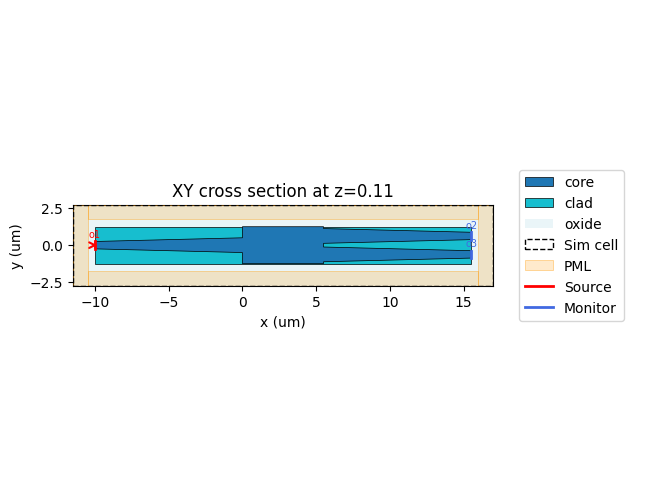

In [8]:
# 2D cross-section at z = center of core layer
sim.plot_2d(slices="z")

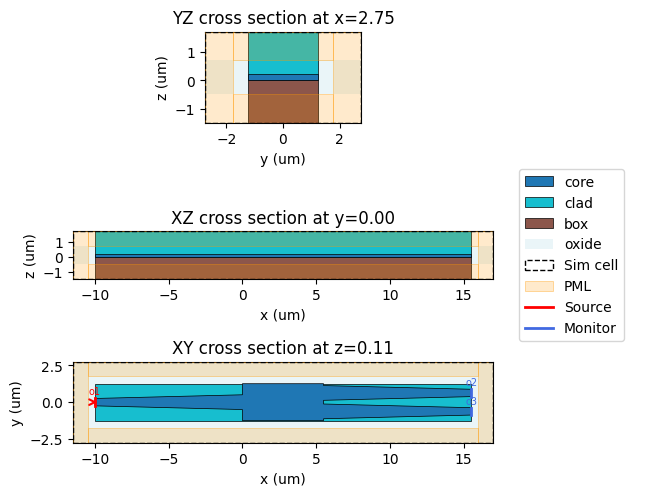

In [9]:
# Multi-view: x, y, z cross-sections
sim.plot_2d(slices="xyz")

## 6. Write config to disk

`write_config()` generates three files:
- `layout.gds` — the GDS layout
- `sim_config.json` — layer stack, ports, materials, FDTD params
- `run_meep.py` — self-contained cloud runner script

In [10]:
output_dir = sim.write_config()
print(f"Config written to: {output_dir}")

# List generated files
import os

for f in sorted(os.listdir(output_dir)):
    size = os.path.getsize(output_dir / f)
    print(f"  {f} ({size:,} bytes)")

Config written to: meep-sim-test
  layout.gds (1,840 bytes)
  run_meep.py (16,293 bytes)
  sim_config.json (3,729 bytes)


/home/vahid/Documents/sims/gsim/src/gsim/meep/sim.py:362: UserWarning: Material 'Aluminum' has no optical properties (refractive_index) — layer will be omitted from simulation. Use sim.set_material('Aluminum', refractive_index=...) to include it.
  material_data = resolve_materials(used_materials, overrides=self.materials)
/home/vahid/Documents/sims/gsim/src/gsim/meep/sim.py:362: UserWarning: Material 'ge' has no optical properties (refractive_index) — layer will be omitted from simulation. Use sim.set_material('ge', refractive_index=...) to include it.
  material_data = resolve_materials(used_materials, overrides=self.materials)


## 7. Inspect generated JSON config

In [11]:
import json

config = json.loads((output_dir / "sim_config.json").read_text())

print(f"=== GDS file: {config['gds_filename']} ===\n")

print(f"=== Layer Stack: {len(config['layer_stack'])} layers ===")
for layer in config["layer_stack"]:
    angle = (
        f", sidewall={layer['sidewall_angle']}deg"
        if layer.get("sidewall_angle")
        else ""
    )
    print(
        f"  {layer['layer_name']}: gds_layer={layer['gds_layer']}, z=[{layer['zmin']}, {layer['zmax']}], material={layer['material']}{angle}"
    )

print(f"\n=== Dielectrics: {len(config.get('dielectrics', []))} ===")
for diel in config.get("dielectrics", []):
    print(f"  {diel['name']}: z=[{diel['zmin']}, {diel['zmax']}], material={diel['material']}")

print(f"\n=== Materials ===")
for name, props in config["materials"].items():
    print(f"  {name}: n={props['refractive_index']}, k={props['extinction_coeff']}")

print(f"\n=== Ports: {len(config['ports'])} ===")
for port in config["ports"]:
    src = " [SOURCE]" if port["is_source"] else ""
    print(
        f"  {port['name']}: center={port['center']}, width={port['width']}, axis={port['normal_axis']}{src}"
    )

print(f"\n=== FDTD ===")
print(f"  wavelength: {config['fdtd']['wavelength']} um")
print(f"  fcen: {config['fdtd']['fcen']:.4f}")
print(f"  df: {config['fdtd']['df']:.4f}")
print(f"  num_freqs: {config['fdtd']['num_freqs']}")
print(f"  resolution: {config['resolution']['pixels_per_um']} px/um")

stopping = config["fdtd"].get("stopping", {})
print(f"\n=== Stopping ===")
print(f"  mode: {stopping.get('mode', 'fixed')}")
print(f"  run_after_sources: {stopping.get('run_after_sources', config['fdtd'].get('run_after_sources'))}")
if stopping.get("mode") == "decay":
    print(f"  decay_by: {stopping['decay_by']}")
    print(f"  decay_dt: {stopping['decay_dt']}")
    print(f"  decay_component: {stopping['decay_component']}")

print(f"\n=== Domain / PML ===")
domain = config.get("domain", {})
print(f"  dpml: {domain.get('dpml', 'N/A')} um")
print(f"  margin_xy: {domain.get('margin_xy', 'N/A')} um")
print(f"  margin_z_above: {domain.get('margin_z_above', 'N/A')} um")
print(f"  margin_z_below: {domain.get('margin_z_below', 'N/A')} um")

print(f"\n=== Symmetries: {len(config.get('symmetries', []))} ===")
for sym in config.get("symmetries", []):
    print(f"  Mirror {sym['direction']}, phase={sym.get('phase', 1)}")

print(f"\n=== Performance ===")
print(f"  split_chunks_evenly: {config.get('split_chunks_evenly', False)}")

=== GDS file: layout.gds ===

=== Layer Stack: 10 layers ===
  box: gds_layer=[999, 0], z=[-0.5, 0.0], material=sio2
  core: gds_layer=[0, 0], z=[0.0, 0.22], material=si, sidewall=10.0deg
  shallow_etch: gds_layer=[0, 0], z=[0.0, 0.07], material=si
  deep_etch: gds_layer=[3, 6], z=[0.0, 0.13], material=si
  clad: gds_layer=[999, 0], z=[0.0, 0.72], material=sio2
  slab150: gds_layer=[2, 0], z=[0.0, 0.15], material=si
  slab90: gds_layer=[3, 0], z=[0.0, 0.09], material=si
  nitride: gds_layer=[34, 0], z=[0.32, 0.67], material=sin
  ge: gds_layer=[5, 0], z=[0.22, 0.72], material=ge
  via_contact: gds_layer=[40, 0], z=[0.09, 0.72], material=Aluminum, sidewall=-10.0deg

=== Dielectrics: 1 ===
  oxide: z=[-0.5, 0.72], material=SiO2

=== Materials ===
  SiO2: n=1.44, k=0.0
  si: n=3.47, k=0.0
  sin: n=2.0, k=0.0
  sio2: n=1.44, k=0.0

=== Ports: 3 ===
  o1: center=[-10.0, 0.0, 0.11], width=0.5, axis=0 [SOURCE]
  o2: center=[15.5, 0.625, 0.11], width=0.5, axis=0
  o3: center=[15.5, -0.625, 0.1

## 8. Inspect generated runner script

In [12]:
script = (output_dir / "run_meep.py").read_text()
# Show first 40 lines
for i, line in enumerate(script.splitlines()[:40], 1):
    print(f"{i:3d} | {line}")

  1 | #!/usr/bin/env python3
  2 | """Auto-generated MEEP runner script.
  3 | 
  4 | Reads simulation config from JSON + layout from GDS, builds geometry,
  5 | runs FDTD, and extracts S-parameters via mode decomposition.
  6 | 
  7 | Cloud dependencies: meep, gdsfactory, numpy, scipy, shapely
  8 | """
  9 | 
 10 | import csv
 11 | import cmath
 12 | import json
 13 | import math
 14 | import sys
 15 | 
 16 | import meep as mp
 17 | import numpy as np
 18 | 
 19 | 
 20 | # ---------------------------------------------------------------------------
 21 | # Config loading
 22 | # ---------------------------------------------------------------------------
 23 | 
 24 | def load_config(path):
 25 |     """Load simulation config from JSON file."""
 26 |     with open(path) as f:
 27 |         return json.load(f)
 28 | 
 29 | 
 30 | # ---------------------------------------------------------------------------
 31 | # Materials
 32 | # --------------------------------------------------------

## 9. Parse S-parameter results (demo with mock data)

In production, `sim.simulate()` sends the config to the cloud and returns parsed results.  
Here we demo the result parsing with mock CSV data.

In [13]:
import numpy as np
from gsim.meep import SParameterResult

# Create mock S-parameter CSV (as if returned from cloud)
mock_csv = output_dir / "s_parameters.csv"

# Parse results
result = SParameterResult.from_csv(mock_csv)
print(f"Wavelengths: {len(result.wavelengths)} points")
print(f"S-params: {list(result.s_params.keys())}")
print(f"Port names: {result.port_names}")

FileNotFoundError: [Errno 2] No such file or directory: 'meep-sim-test/s_parameters.csv'

In [ ]:
# Plot S-parameters (dB scale)
fig = result.plot(db=True)
fig.suptitle("MMI 1x2 — Mock S-Parameters")

## 10. Full workflow summary

```python
from gsim.meep import MeepSim

sim = MeepSim()
sim.set_geometry(component)
sim.set_stack()
sim.set_domain(0.5, dpml=1.0)        # 0.5um margins (default), 1um PML
sim.set_z_crop()
sim.set_material("si", refractive_index=3.47)
sim.set_wavelength(
    wavelength=1.55, bandwidth=0.1,
    stop_when_decayed=True,           # decay-based stopping (1.5-3x faster)
)
sim.set_resolution(pixels_per_um=32)
sim.set_symmetry(y=-1)               # mirror symmetry (2-4x faster)
sim.set_output_dir("./meep-sim-test")

# Visualize before running (shows PML, ports, sim cell, dielectrics)
sim.plot_2d(slices="xyz")

# Run on GDSFactory+ cloud (requires auth)
result = sim.simulate()
result.plot()
```

## 10b. Minimal (all defaults — 0.5um margins, 11 freqs, fixed stopping)

```python
from gsim.meep import MeepSim

sim = MeepSim()
sim.set_geometry(component)
sim.set_stack()
sim.set_z_crop()
sim.set_material("si", refractive_index=3.47)
sim.set_wavelength(wavelength=1.55, bandwidth=0.1)
sim.set_resolution(pixels_per_um=32)
sim.set_output_dir("./meep-sim-test")

# Visualize before running
sim.plot_2d(slices="z")

# Run on GDSFactory+ cloud (requires auth)
result = sim.simulate()
result.plot()
```